# Sentiment Analysis & Prediction from Amazon Product Reviews

## Constants

In [1]:
import pandas as pd
import bokeh
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import string as string
import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

%matplotlib inline

## Get Data

Loading reviews for a set of baby products. 

In [2]:
products = pd.read_csv("data/amazon_baby.csv")

Data includes the product name, the review text and the rating of the review. 

In [3]:
print(products.shape)
products.head(15)

(183531, 3)


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5
6,A Tale of Baby\'s Days with Peter Rabbit,"Lovely book, it\'s bound tightly so you may no...",4
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4


### Basic exploration

##### Data types and Column names

In [4]:
products.dtypes

name      object
review    object
rating     int64
dtype: object

##### Total unique products

In [5]:
len(products.name.unique())

32418

##### Frequency count for each product

In [6]:
product_count = products.name.value_counts()
product_count[0:9]

Vulli Sophie the Giraffe Teether                                            785
Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L                         562
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision    561
Baby Einstein Take Along Tunes                                              547
Cloud b Twilight Constellation Night Light, Turtle                          520
Fisher-Price Booster Seat, Blue/Green/Gray                                  489
Fisher-Price Rainforest Jumperoo                                            450
Graco Nautilus 3-in-1 Car Seat, Matrix                                      419
Leachco Snoogle Total Body Pillow                                           388
Name: name, dtype: int64

##### Plotting the top 15 products based on number of reviews

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

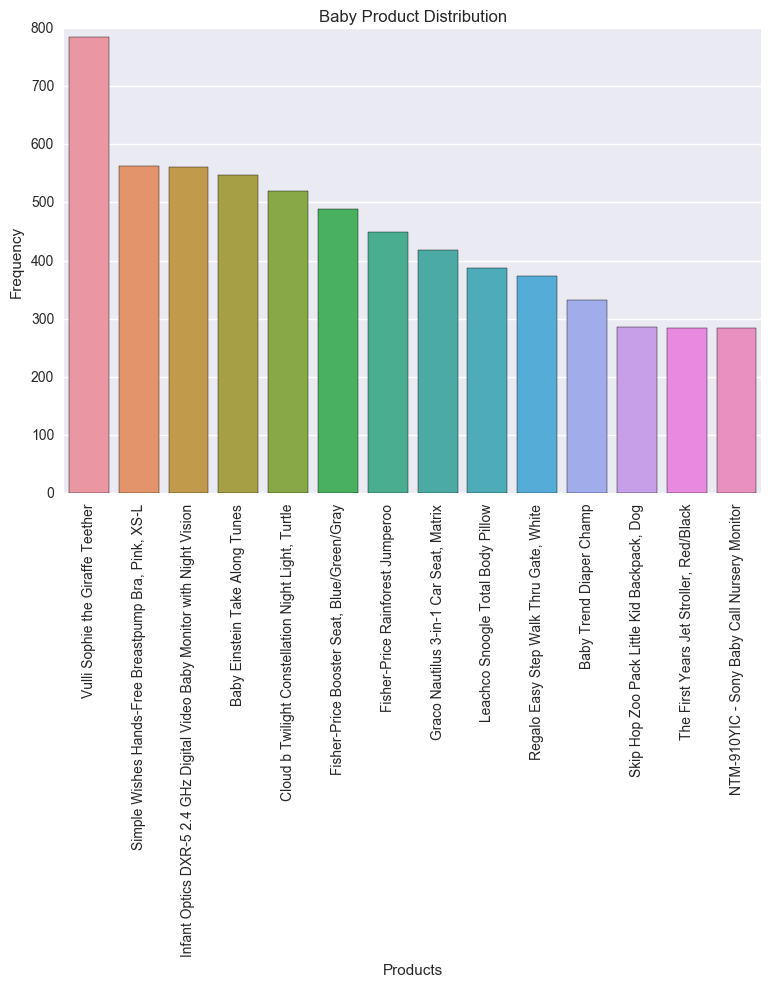

In [7]:
plt.figure(figsize=(9,6))
sns.barplot(x=product_count[0:14].index, y=product_count[0:14])
plt.title('Baby Product Distribution')
plt.xlabel('Products')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

##### Examining the ratings distibution for top 15 products

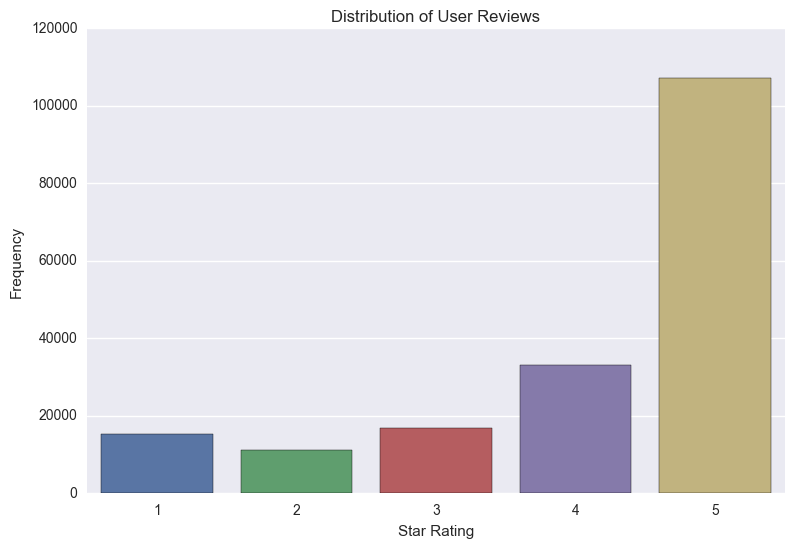

In [8]:
rating_count = products.rating.value_counts()
plt.figure(figsize=(9,6))
sns.barplot(x=rating_count[0:14].index, y=rating_count[0:14])
plt.title('Distribution of User Reviews')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')

##### Examining the ratings for most-reviewed product:  'Vulli Sophie the Giraffe Teether'

Product details as part of the lecture, hence no code for verification.

In [9]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']

In [10]:
giraffe_reviews['rating'].describe()

count    785.000000
mean       4.294268
std        1.227358
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64

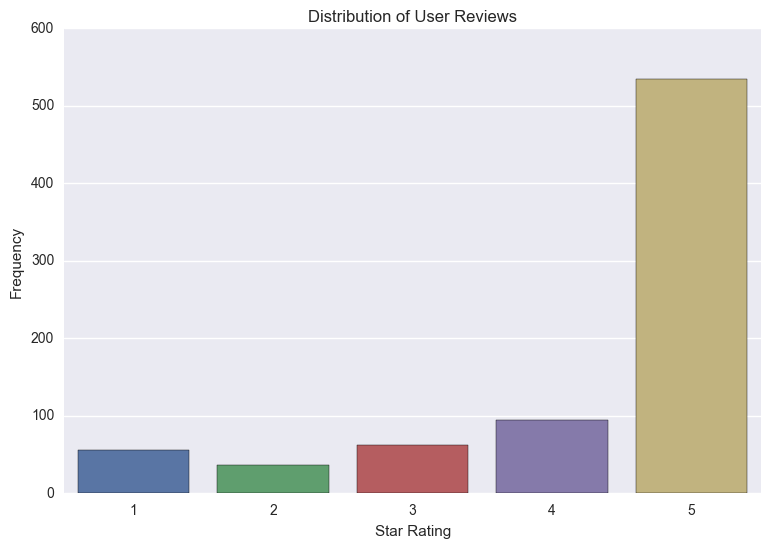

In [11]:
rating_count = giraffe_reviews.rating.value_counts()
plt.figure(figsize=(9,6))
sns.barplot(x=rating_count.index, y=rating_count)
plt.title('Distribution of User Reviews')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')

## Data Transformations

In [12]:
# Create a dictionary using a comprehension - this maps every character from
# string.punctuation to None. Initialize a translation object from it.
translator = str.maketrans({key: None for key in string.punctuation})

In [13]:
def string_to_dict(word_string):
    word_string = str(word_string) # in case the string contains numbers which leads to issues post split
#     word_string = word_string.translate(translator)
    word_string = word_string.lower()
    word_string = re.sub('['+string.punctuation+']', '', word_string)
    word_string = re.sub(r'\d+', '', word_string)
    word_string = word_string.rstrip()
    wordlist = word_string.split()
    wordfreq = []
    for w in wordlist:
        wordfreq.append(wordlist.count(w))
    
    word_dict = dict(zip(wordlist, wordfreq))
    return(word_dict)

In [14]:
print("The below operations are likely to take some time, please be patient")
products["word_count"] = products["review"]
products["word_count"] = products["word_count"].apply(string_to_dict)

print("All Done!")

The below operations are likely to take some time, please be patient
All Done!


In [15]:
products.head()

,name,review,rating,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{'starting': 1, 'to': 2, 'longer': 1, 'about':..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'recommend': 1, 'keps': 1, 'early': 1, 'bags'..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'bed': 1, 'for': 1, 'recommend': 1, 'full': 1..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'else': 1, 'found': 1, 'about': 1, 'losing': ..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'found': 1, 'save': 1, 'to': 5, 'book': 2, 'h..."


## Build a sentiment classifier

##### Defining Sentiment

We will ignore all reviews with rating = 3 which in this case is considered neutral.  Reviews with a rating of 4 or higher will be considered positive or `True`, while the ones with rating of 2 or lower will have a negative sentiment (or `False`)   

In [16]:
#ignore all 3* reviews
products_non_neutral = products[products['rating'] != 3].copy() # copy because dataframe is mutable
idx_length = products_non_neutral.rating.size
products_non_neutral.index = range(idx_length)

In [17]:
#positive sentiment = 4* or 5* reviews
products_non_neutral['sentiment'] = products_non_neutral['rating'] >=4
products_non_neutral.shape

(166752, 5)

In [18]:
products_non_neutral.head()

,name,review,rating,word_count,sentiment
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'recommend': 1, 'keps': 1, 'early': 1, 'bags'...",True
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'bed': 1, 'for': 1, 'recommend': 1, 'full': 1...",True
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'else': 1, 'found': 1, 'about': 1, 'losing': ...",True
3,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'found': 1, 'save': 1, 'to': 5, 'book': 2, 'h...",True
4,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'stop': 1, 'made': 1, 'sucking': 1, 'our': 2,...",True


# Quiz

### Transformations for Quiz

#### Setting up the selected words and creating features

In [19]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [20]:
def filtered_word_count(series_of_dicts, list_of_keys):
    """
    series_of_dicts must be a panda series where each record is a dictionary
    list_of_keys should be the list of keys that are needed to be retained
    
    both parameters are mandatory
    """
    idx = series_of_dicts.index
    iter = series_of_dicts.size
    selected_words_count = []
    for i in range(iter):
        old_dict = series_of_dicts[i]
        new_dict = {k: old_dict[k] for k in set(selected_words) & set(old_dict.keys())}
        selected_words_count.append(new_dict)
    selected_words_count = pd.Series(selected_words_count)
    return (selected_words_count)

In [21]:
selected_words_count = filtered_word_count(products_non_neutral.word_count, list_of_keys=selected_words)

In [22]:
products_non_neutral["selected_words_count"] = selected_words_count

In [23]:
products_non_neutral.head()

,name,review,rating,word_count,sentiment,selected_words_count
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'recommend': 1, 'keps': 1, 'early': 1, 'bags'...",True,{'love': 1}
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'bed': 1, 'for': 1, 'recommend': 1, 'full': 1...",True,{}
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'else': 1, 'found': 1, 'about': 1, 'losing': ...",True,{'love': 2}
3,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'found': 1, 'save': 1, 'to': 5, 'book': 2, 'h...",True,{'great': 1}
4,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'stop': 1, 'made': 1, 'sucking': 1, 'our': 2,...",True,{'great': 1}


#### Featurizing the selected words

Using pandas and sklearn to generate features from a dictionary. There maybe better solutions out there, and possible efficient as well, however I used this approach given the less time I had to complete the assignment.

In [24]:
DV = DictVectorizer(sparse=False)
dummies = DV.fit_transform(products_non_neutral.selected_words_count)
col_list = DV.get_feature_names()
print(type(dummies))
print(type(col_list))

<class 'numpy.ndarray'>
<class 'list'>


In [25]:
feature_dummies = pd.DataFrame(dummies, columns=col_list)
feature_dummies.head()

,amazing,awesome,awful,bad,fantastic,great,hate,horrible,love,terrible,wow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
amazon_reviews = pd.concat([products_non_neutral, feature_dummies], axis=1) # axis 1 to join on as columns rather than rows
amazon_reviews.head(3)

,name,review,rating,word_count,sentiment,selected_words_count,amazing,awesome,awful,bad,fantastic,great,hate,horrible,love,terrible,wow
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'recommend': 1, 'keps': 1, 'early': 1, 'bags'...",True,{'love': 1},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'bed': 1, 'for': 1, 'recommend': 1, 'full': 1...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'else': 1, 'found': 1, 'about': 1, 'losing': ...",True,{'love': 2},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


### Question 1 & 2

1. Out of the `selected_words`, which one is most used in the dataset? 
2. Which one is least used?

In [27]:
print("amazing: ", amazon_reviews.amazing.sum())
print("awesome: ", amazon_reviews.awesome.sum())
print("awful: ", amazon_reviews.awful.sum())
print("bad: ", amazon_reviews.bad.sum())
print("fantastic: ", amazon_reviews.fantastic.sum())
print("great: ", amazon_reviews.great.sum())
print("hate: ", amazon_reviews.hate.sum())
print("horrible: ", amazon_reviews.horrible.sum())
print("love: ", amazon_reviews.love.sum())
print("terrible: ", amazon_reviews.terrible.sum())
print("wow: ", amazon_reviews.wow.sum())

amazing:  2542.0
awesome:  3741.0
awful:  661.0
bad:  4054.0
fantastic:  1607.0
great:  54420.0
hate:  1091.0
horrible:  1087.0
love:  41522.0
terrible:  1103.0
wow:  389.0


### Question 3 & 4

3. Out of the `selected_words`, which one has the most postive weight in the `selected_words_model`? 
4. Which one has the most negative weight?

##### Creating the selected_words_model

Train a logistic regression classifier using just the `selected_words` as features. Look at the coefficients to gain insights into the weight. 

###### train, test

In [28]:
random.seed(0)
train_data,test_data = model_selection.train_test_split(amazon_reviews, test_size = 0.2)

In [29]:
print("Shape of Training data:", train_data.shape)
print("Shape of Testing data:", test_data.shape)
train_data.head()

Shape of Training data: (133401, 17)
Shape of Testing data: (33351, 17)


,name,review,rating,word_count,sentiment,selected_words_count,amazing,awesome,awful,bad,fantastic,great,hate,horrible,love,terrible,wow
100945,"Graco Portland Combo Dresser, White",I like the color of this product. This product...,5,"{'goes': 1, 'color': 1, 'put': 1, 'hard': 1, '...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20791,"BABYBJORN Soft Bib, Red",We\'ve used 2 of these bibs continuously for 2...,5,"{'children': 1, 'years': 1, 'old': 1, 'our': 1...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41440,"Tiny Love Take-Along Arch, Sunny Stroll",My baby loved it so much. It attracts her atte...,5,"{'every': 1, 'attach': 2, 'about': 1, 'loved':...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121175,"Boppy Shopping Cart Cover, Deco Stripe","I haven\'t used this much yet, but I am still ...",4,"{'still': 1, 'am': 1, 'confused': 1, 'used': 1...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87778,"Thermos FOOGO Phases Straw Bottle, Blue/Yellow...",I purchased this thermos because of the ease o...,5,"{'easy': 1, 'expected': 1, 'arrived': 2, 'they...",True,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### creating classifier

In [30]:
X = pd.DataFrame(train_data, columns=selected_words)
y = train_data.sentiment.copy()

In [31]:
print(y.head())
X.head()

100945    True
20791     True
41440     True
121175    True
87778     True
Name: sentiment, dtype: bool


,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate
100945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### logit model

In [32]:
model = LogisticRegression()
selected_words_model = model.fit(X,y)

In [33]:
selected_words_model.score(X,y)

0.84695766898299119

In [34]:
model_coeffs = (np.transpose(selected_words_model.coef_))
model_coeffs = map(lambda x: x[0], model_coeffs)
coefficients = pd.Series(model_coeffs)

In [35]:
pd.DataFrame(X.columns.values, coefficients)

,0
1.182474,awesome
0.874742,great
0.884660,fantastic
1.032005,amazing
1.381050,love
-2.296061,horrible
-0.995814,bad
-2.216800,terrible
-2.043440,awful
-0.045385,wow


From the value of coefficients and selected words, we can see that the values for most postive and most negative are for `love` and `terrible`. Depending on your seed value, you may get `horrible` as the answer which is just `terribly` bad luck for the quiz.

### Question 5

In what range is the accracy  of the `selected_words_model` on the `test_data`?

In [36]:
X_test = pd.DataFrame(test_data, columns=selected_words)
y_test = test_data.sentiment.copy()
selected_words_model.score(X_test,y_test)

0.84837036370723518

Given the above value of accuracy, the range is `0.841 to 0.871`

### Question 6

In what range is the accracy  of the `sentiment_model` on the `test_data`? 

_Note_: 
1. Refer to the lecture **Training a sentiment classifier** for the `sentiment_model` definition and training vs test split. 
2. The `sentiment_model` uses the `products` data which is transformed as `products_non_neutral` in this notebook.

All the below code should work fine provided there is enough memory. I am using a 64bit python on a 64 bit machine, however the size of the features is more than 100,000 which is creating a out of memory error. 

There are other ways, that can bring in more efficiency, including reducing the features by removing parse words, stemming and lemmatization, however due to paucity of time, it has not been tried.

To answer the question, I have used qualitative assessment on the values. If the accuracy on selected words is 84% and has 11 features, given the number of features availble for sentiment model, an educated guess is of accuracy greater than 90%.

###### creating dummies

In [37]:
# DV = DictVectorizer(sparse=False) 
# dummies = DV.fit_transform(products_non_neutral.word_count)
# col_list = DV.get_feature_names()
# print(type(dummies))
# print(type(col_list))

In [38]:
# len(col_list) # the data has already been case converted, puntuation & numbers dropped

In [39]:
# feature_dummies = pd.DataFrame(dummies, columns=col_list)
# feature_dummies.shape

In [40]:
# amazon_reviews = pd.concat([products_non_neutral, feature_dummies], axis=1) # axis 1 to join on as columns rather than rows
# amazon_reviews.head(3)

###### train, test

In [41]:
# random.seed(0)
# train_data,test_data = model_selection.train_test_split(amazon_reviews, test_size = 0.2)

In [42]:
# X = pd.DataFrame(train_data, columns= col_list)
# y = train_data.sentiment.copy()

In [43]:
# sentiment_model = model.fit(X,y)
# sentiment_model.score(X,y)

In [44]:
# X_test = pd.DataFrame(test_data, columns=col_list)
# y_test = test_data.sentiment.copy()
# sentiment_model.score(X_test,y_test)

### Question 7

In what range is the accracy  of simply predicting the majority class on the `test_data`?

Now a baseline approach for majority class can be either assuming all predictions are same as the majority class. Another approach could be random guessing. For this question, all predictions belong to majority class is used.

###### majority class

In [45]:
print(test_data.sentiment.sum())
test_data.shape

28062


(33351, 17)

###### accuracy for majority class

In [46]:
test_data.sentiment.sum() /  test_data.shape[0]

0.84141405055320684

### Question 8

How do you compare the different learned models  with the baseline approach where we are just predicting the majority class?

**Answer**:

Accuracy for base line approach  : approx 84%  
Accuracy for selected words model: approx 85%  
Accuracy for sentiment model     : approx 90%  

So sentment model performed much better than other two. The other two performed about the same.

### Question 9

In what range is the `predicted_sentiment` for the most positive review for the `Baby Trend Diaper Champ` according to the `sentiment_model`?

###### train, test

In [47]:
baby_trend = products_non_neutral[products_non_neutral['name'] == 'Baby Trend Diaper Champ'].copy()
idx_length = baby_trend.rating.size
baby_trend.index = range(idx_length)

In [48]:
DV = DictVectorizer(sparse=False) 
dummies = DV.fit_transform(baby_trend.word_count)
col_list = DV.get_feature_names()

In [49]:
new_list = []
for item in col_list:
    item = item.replace("\\","")
    new_list.append(item)
print(new_list[0:10])

['champ', 'diaper', 'howd', 'n', 'potent', 'r', 'thud', 'a', 'ability', 'able']


In [50]:
feature_dummies = pd.DataFrame(dummies, columns=new_list)

In [51]:
print(feature_dummies.shape)
baby_trend.shape

(298, 2872)


(298, 6)

In [52]:
feature_dummies.head()

,champ,diaper,howd,n,potent,r,thud,a,ability,able,...,your,yours,yourself,yowlingthis,yr,yuck,zero,zip,ziplock,ziplocs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
baby_trend_reviews = pd.concat([baby_trend, feature_dummies], axis=1) # axis 1 to join on as columns rather than rows4
baby_trend_reviews.head(2)

,name,review,rating,word_count,sentiment,selected_words_count,champ,diaper,howd,n,...,your,yours,yourself,yowlingthis,yr,yuck,zero,zip,ziplock,ziplocs
0,Baby Trend Diaper Champ,Ok - newsflash. Diapers are just smelly. We\...,4,"{'children': 1, 'our': 3, 'so': 1, 'didn\t': 2...",True,{},0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baby Trend Diaper Champ,"My husband and I selected the Diaper ""Champ"" m...",1,"{'ordinary': 1, 'clorox': 1, 'positivethe': 1,...",False,{},0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# train, test = model_selection.train_test_split(baby_trend_reviews, test_size = 0.2)
train_data = baby_trend_reviews.sample(frac=0.8, random_state=0)
test_data = baby_trend_reviews.loc[~baby_trend_reviews.index.isin(train_data.index)]

print(train_data.shape)
print(test_data.shape)

(238, 2878)
(60, 2878)


###### model

In [55]:
X_all = baby_trend_reviews.ix[:,6:2878].copy()
X = train_data.ix[:,6:2878].copy()
y = train_data.sentiment.copy()

In [56]:
sentiment_model = model.fit(X,y)
model.score(X,y)

1.0

###### prediction on test

In [57]:
X_test = test_data.ix[:,6:2878].copy()
y_test = test_data.sentiment.copy()

In [58]:
y_pred = sentiment_model.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.60      0.38      0.46         8
       True       0.91      0.96      0.93        52

avg / total       0.87      0.88      0.87        60



###### predicted sentiment

In [60]:
predicted_sentiment = sentiment_model.predict_proba(X_all) * 100

In [61]:
np.set_printoptions(suppress=True)
print(sentiment_model.classes_)
prediction_probabilities = pd.DataFrame(data=predicted_sentiment, columns=["False", "True"])
max(prediction_probabilities["True"])

[False  True]


99.999962849896988

As can be seen from the above value, that we do have a probability of _99.99%_ for the most positive review. We can easily comclude that the predicted_sentiment will be between **0.9 to 1.0**

### Question 10

Consider the most positive review for the `Baby Trend Diaper Champ` according to the `sentiment_model`
In what range is the `predicted_sentiment` for this review if the `selected_words_model` is used?

In [ ]:
# getting the index of the most positive review.
prediction_probabilities[prediction_probabilities['True'] == max(prediction_probabilities["True"])].index.tolist() 

###### train, test

In [ ]:
baby_trend_reviews_2 = amazon_reviews[amazon_reviews['name'] == 'Baby Trend Diaper Champ'].copy()
idx_length = baby_trend_reviews_2.rating.size
baby_trend_reviews_2.index = range(idx_length)

In [ ]:
baby_trend_reviews_2.shape

In [ ]:
X_all = baby_trend_reviews_2.ix[:,6:17].copy()

In [ ]:
predicted_sentiment = selected_words_model.predict_proba(X_all) * 100

In [ ]:
np.set_printoptions(suppress=True)
print(selected_words_model.classes_)
prediction_probabilities = pd.DataFrame(data=predicted_sentiment, columns=["False", "True"])
max(prediction_probabilities["True"])

In [ ]:
prediction_probabilities.loc[181]

### Question 11

Consider answers to question 9 & 10 above.
Why is the value of the `predicted_sentiment` using `sentiment_model` much more positive than the `selected_words_model`?